# VanDerPol Reachability Analysis Example

This example demonstrates a complete workflow for reachability verification analysis using the VanDerPol system.

| Item                             | Description                                                                                                                                                                                                                                    |
| -------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dynamical System**             | VanDerPol                                                                                                                                                                                                                                      |
| **Dimension**                    | 2D                                                                                                                                                                                                                                             |
| **Expected Verification Result** | Reachable                                                                                                                                                                                                                                      |
| **Eigenpairs**                   | Principal eigenpairs with feasible residuals                                                                                                                                                                                                   |
| **Experiment Objective**         | Extract the system's eigenfunctions through the Residual Dynamic Mode Decomposition (ResDMD) algorithm, and perform reachability bound computation based on these eigenfunctions to verify reachability from the initial set to the target set |
| **Remark**                       | This script obtains data from the band zone of the limit cycle (within specified radius)                                                                                                                                                       |


In [1]:
# load the modules
import os
import sys

sys.path.append("../")

import numpy as np
import ddrv

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
/Users/jianqiang/Downloads/Residual-Dynamic-Mode-Decomposition-1/examples/../ddrv/viz/vis_vector_field_2d.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


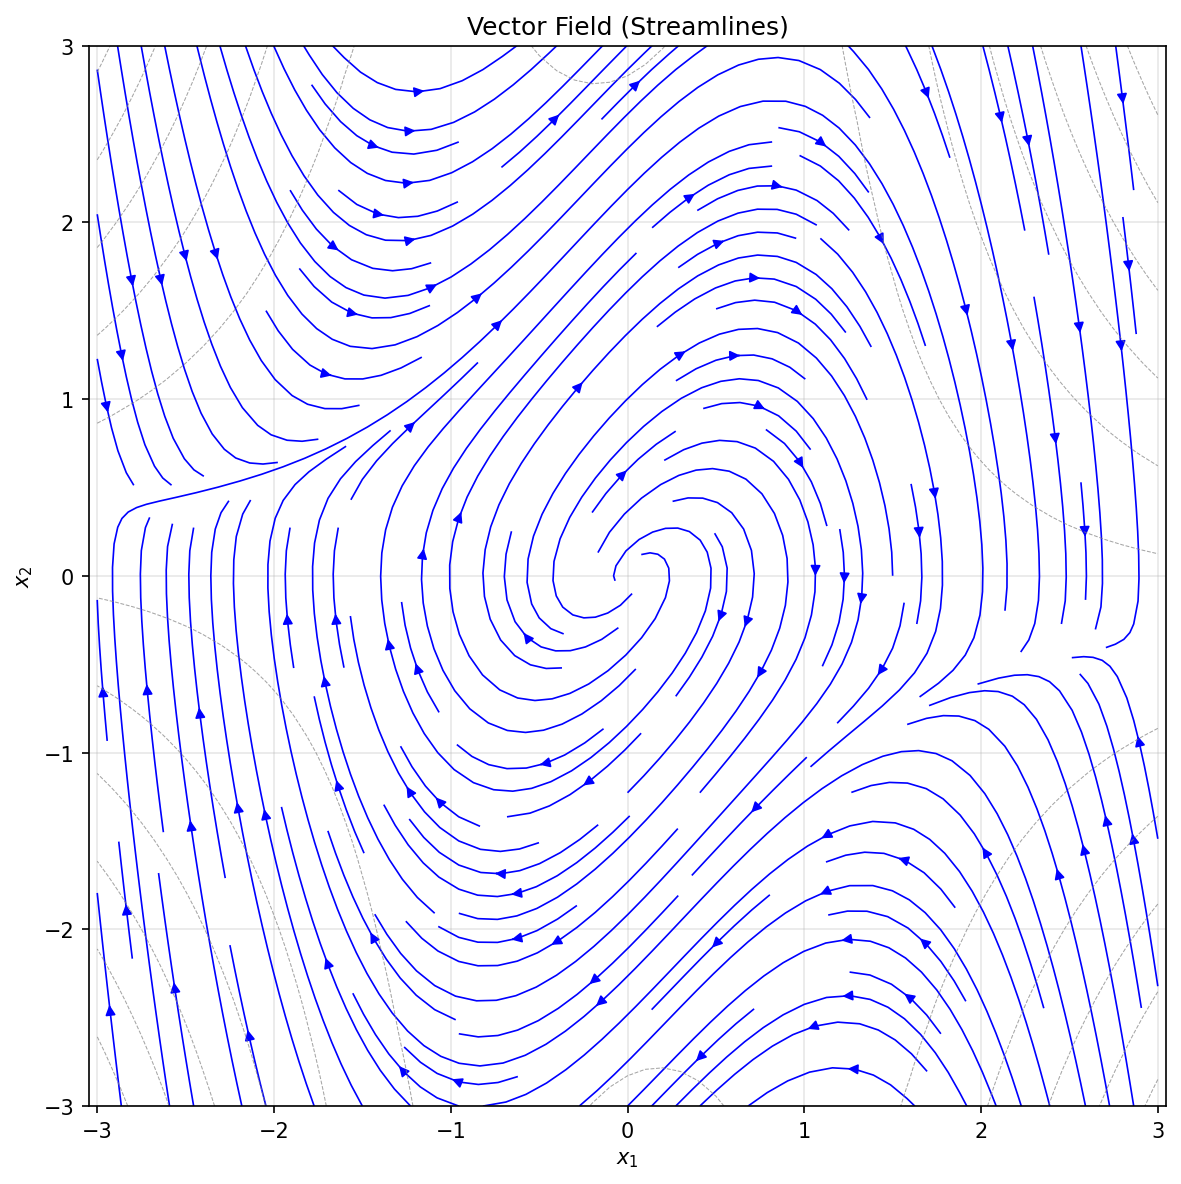

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'center': 'Vector Field (Streamlines)'}, xlabel='$x_1$', ylabel='$x_2$'>)

In [2]:
# define the dynamical system
vanderpol = ddrv.dynamic.Vanderpol()
ddrv.viz.vis_vector_field_2d(
    vanderpol.get_numerical_dynamics(),
    domain=[[-3, 3], [-3, 3]],
    step_size=0.1,
)

(2001, 3, 2)


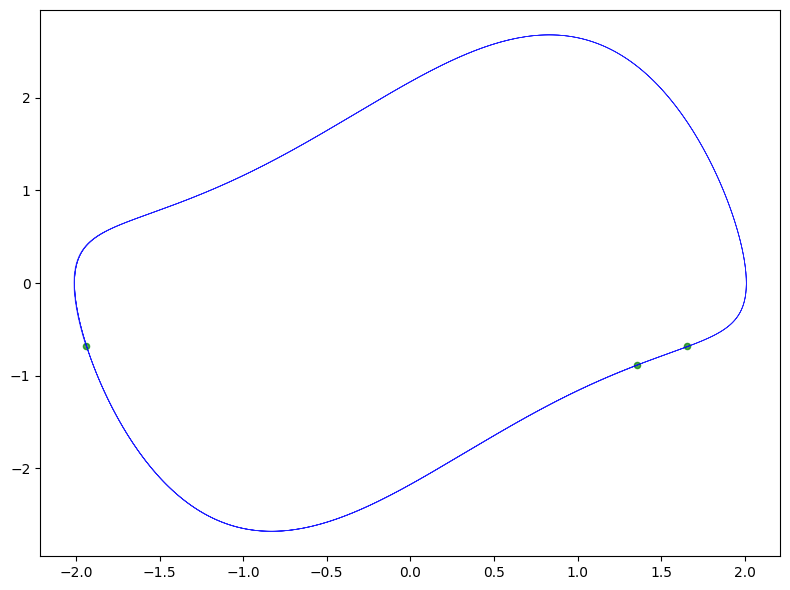

In [3]:
DT = 0.01
RANDOM_SEED = 0

# now simulate from one initial point to get the trajectory data of the limit cycle
initial_point = np.array(
    [[-1.9, 0.0], [1.5, 3], [-2, 1]]
)  # random picked three points for generating the limit cycle
traj_data_LMC, _ = ddrv.common.simulate(
    vanderpol.get_numerical_dynamics(),
    initial_point,
    0,
    20,
    DT,
)
print(traj_data_LMC.shape)
# truncate the trajectory data to the limit cycle
traj_data_LMC = traj_data_LMC[400:, :, :]

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data_LMC)

# now we have some data accurately on the limit cycle for the following steps
traj_data_LMC = traj_data_LMC.reshape(-1, 2)

(1770, 2)


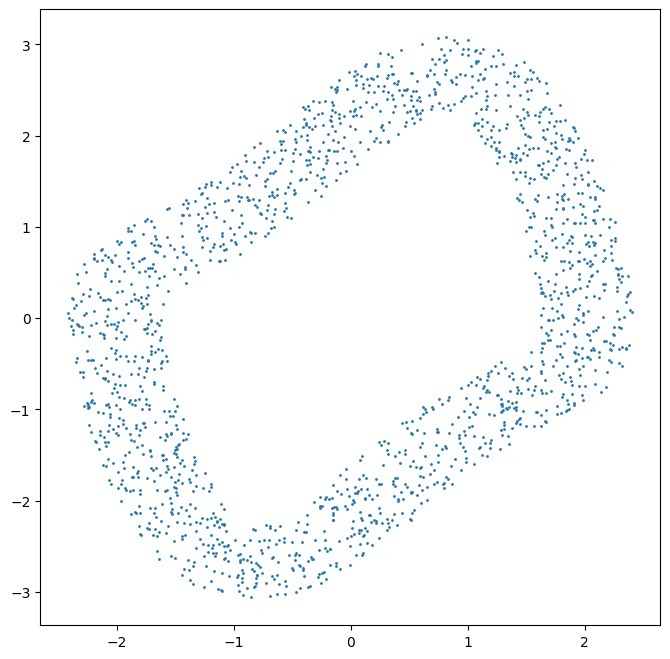

In [4]:
# get the data from the band zone of the limit cycle
# we use the kd-tree to find the points within a certain radius to the limit cycle data

pts_domain = ddrv.common.sample_box_set(
    domain=[[-4, 4], [-4, 4]],
    num_samples=10000,
)
# find from the initial points those within a certain radius to the limit cycle data
band_radius = 0.4
band_points, _ = ddrv.common.sample_rnn_from_points(
    data=pts_domain, query=traj_data_LMC, r=band_radius
)
print(band_points.shape)

# visualize the band zone data
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(band_points[:, 0], band_points[:, 1], s=1)
plt.show()

(61, 300, 2)


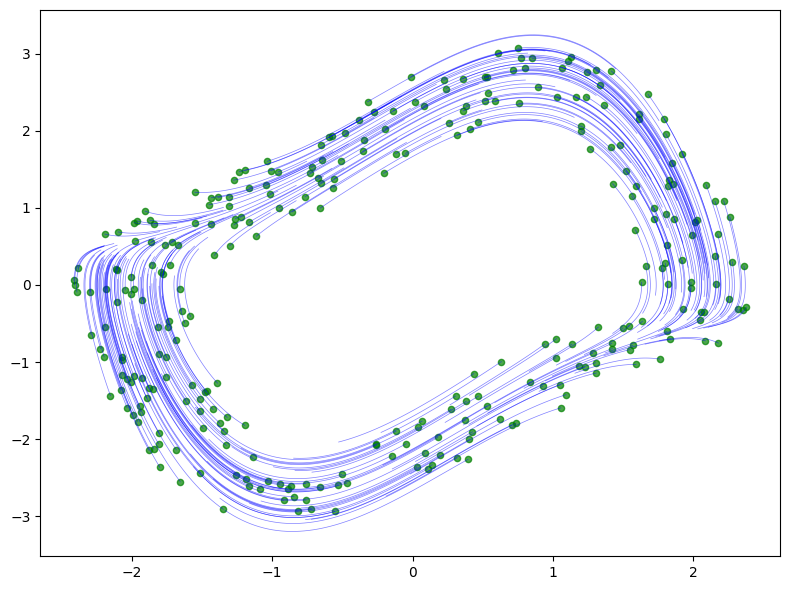

In [5]:
NUM_INIT_PTS = 300
# select randomly NUM_INIT_PTS from the band zone data
init_pts = band_points[
    np.random.choice(band_points.shape[0], NUM_INIT_PTS, replace=False), :
]

# now compute the forward trajectories of the band zone data
traj_data = ddrv.common.generate_trajectory_from_points(
    vanderpol,
    points=init_pts,
    num_steps=60,
    dt=DT,
)

print(traj_data.shape)

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data)

In [6]:
# now split the trajectory data into X and Y arrays, X are the current states, Y are the next states
X = traj_data[:-1, :, :].reshape(-1, 2)
Y = traj_data[1:, :, :].reshape(-1, 2)
print(X.shape, Y.shape)

(18000, 2) (18000, 2)


In [ ]:
# get the principal eigenpairs
LAM, V, residuals, observables, PX, PY, K = ddrv.algo.presdmd(
    traj_data,
    k=6,  # here k=6 is the number of eigenvalues we want to keep finally
    dt=DT,
    observe_params={"basis": "poly", "degree": 13},
)

print(LAM, "LAM")

# compute the continuous principal eigenvalues
LAM_ct = np.log(LAM) / DT
print(
    LAM_ct, "LAM_ct"
)  # but finally only 2 principal eigenvalues and eigenfunctions I got

print(residuals, "residuals")

[] LAM
[] LAM_ct
[] residuals


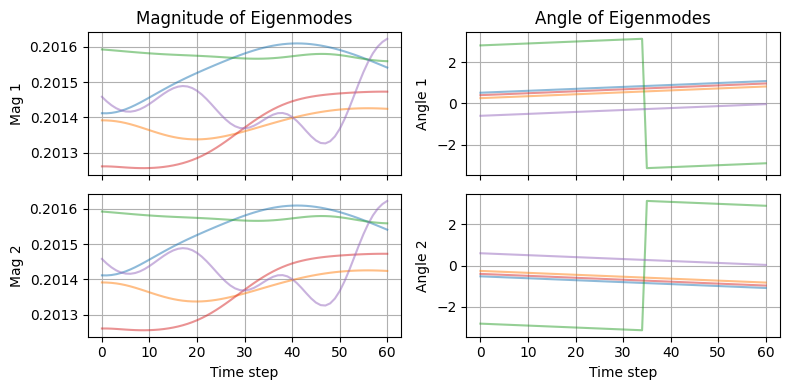

In [8]:
# randomly pick some trajectories to check the obtained eigenfunctions
num_check_traj = 5
check_traj_indices = np.random.choice(traj_data.shape[1], num_check_traj, replace=False)
traj_data_check = traj_data[:, check_traj_indices, :]

ddrv.viz.vis_eigenmodes_along_trajectory(traj_data_check, V, observables)

(500, 2) (500, 2)
(500, 2) (500, 2)
[np.float64(0.3827959160025923),np.float64(22.424163240207303)] >>>> bound_mag
[np.float64(-2.491700554291397),np.float64(-2.0498219925171814)] >>>> bound_img
3 ('PROBABLY REACHABLE', 3)
[(np.float64(4.1719674872568095), np.float64(4.613846049031025)), (np.float64(10.835635528805016), np.float64(11.277514090579231)), (np.float64(17.49930357035322), np.float64(17.941182132127437))]


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


finshed simulation


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


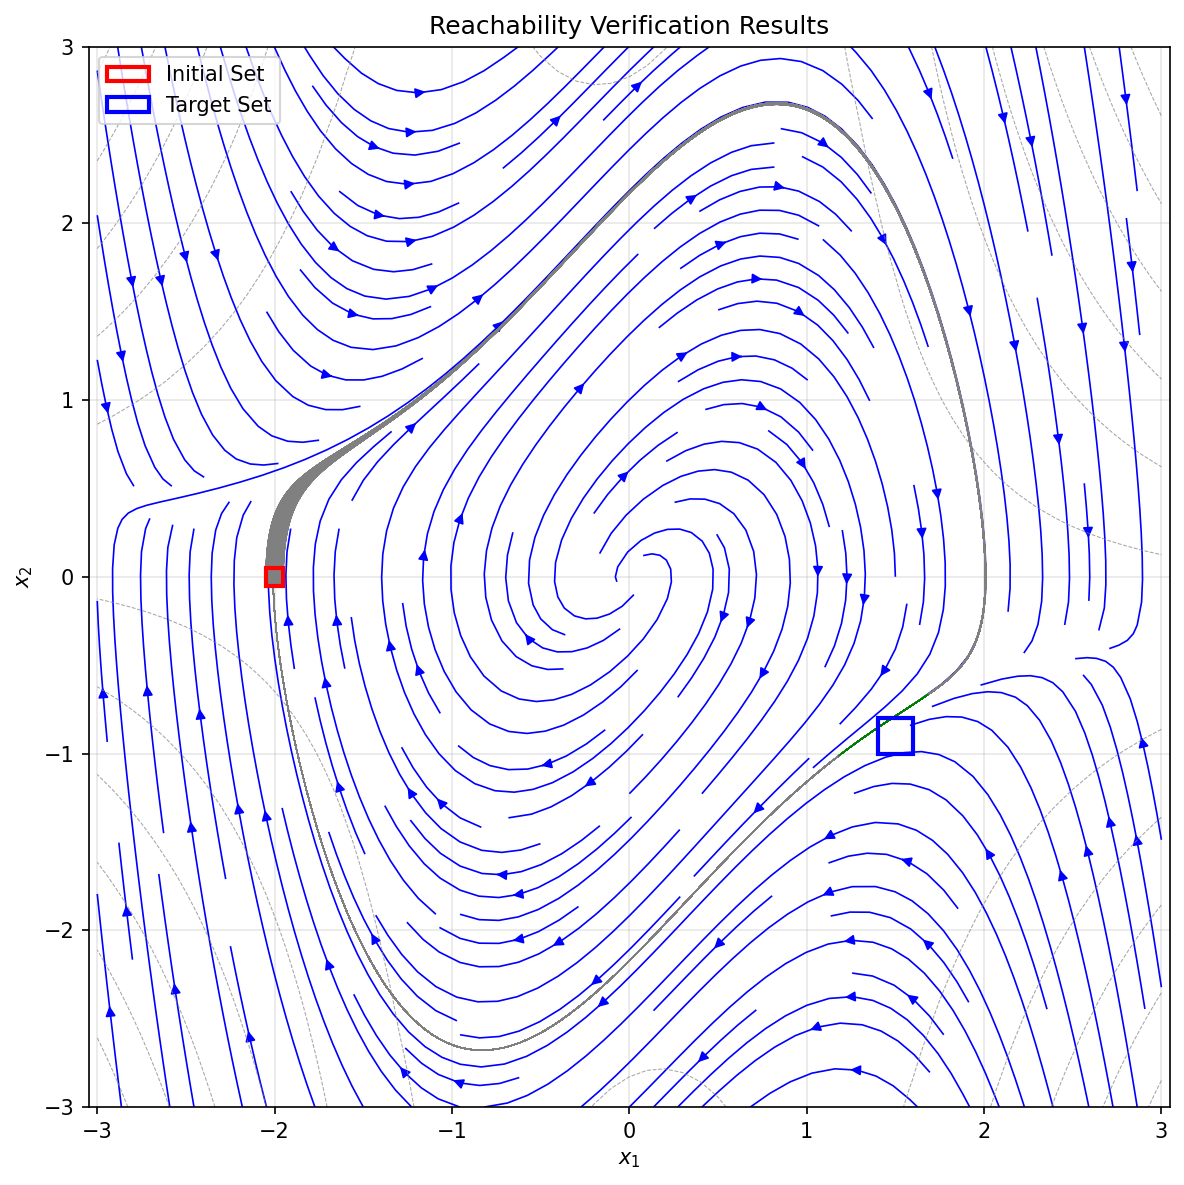

In [9]:
# now with these obtained eigenpairs, we can perform the reachability verification
# CAUTION: for this settings, we got result that align with the simulation

# define the initial set and the target set
X0 = [[-2.05, -1.95], [-0.05, 0.05]]
XT = [[1.4, 1.6], [-1.0, -0.8]]

pts_X0 = ddrv.common.sample_box_set(X0, 500)
pts_XT = ddrv.common.sample_box_set(XT, 500)


print(pts_X0.shape, pts_XT.shape)

# evaluate the eigenfunctions on the initial set and the target set samples
ef0_vals = observables.eval_mod(pts_X0, V)
efT_vals = observables.eval_mod(pts_XT, V)
print(ef0_vals.shape, efT_vals.shape)

# compute the reach time bounds
time_bounds, status = ddrv.algo.compute_reach_time_bounds(ef0_vals, efT_vals, LAM_ct)

print(len(time_bounds), status)
print(time_bounds)

# visualize the reachability verification result
ddrv.viz.vis_rv(
    vanderpol.get_numerical_dynamics(),
    domain=[[-3, 3], [-3, 3]],
    bounds=time_bounds,
    dt=DT,
    initial_set=X0,
    target_set=XT,
)

(500, 2) (500, 2)
(500, 2) (500, 2)
[np.float64(-1837.37697656114),np.float64(-24.840524173932263)] >>>> bound_mag
[np.float64(-3.244682016452398),np.float64(-2.649229883370921)] >>>> bound_img
0 ('UNREACHABLE', 0)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


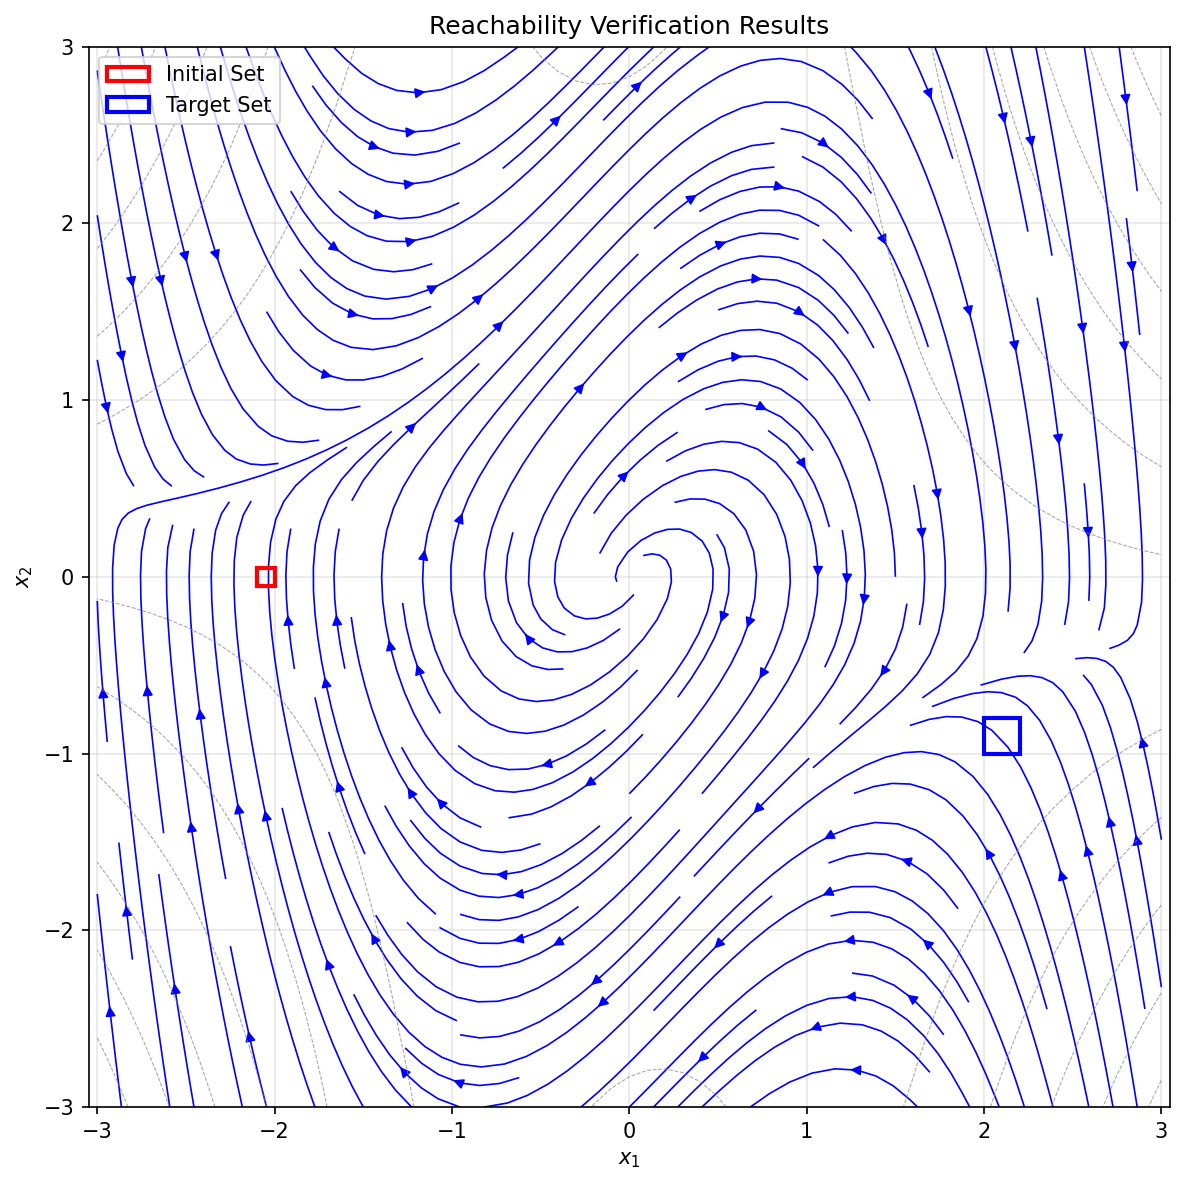

In [10]:
# now checking another initial set and target set

# CAUTION: for this settings, we got result that not align with the simulation

X0 = [[-2.1, -2], [-0.05, 0.05]]
XT = [[2.0, 2.2], [-1.0, -0.8]]

pts_X0 = ddrv.common.sample_box_set(X0, 500)
pts_XT = ddrv.common.sample_box_set(XT, 500)


print(pts_X0.shape, pts_XT.shape)

# evaluate the eigenfunctions on the initial set and the target set samples
ef0_vals = observables.eval_mod(pts_X0, V)
efT_vals = observables.eval_mod(pts_XT, V)
print(ef0_vals.shape, efT_vals.shape)

# compute the reach time bounds
time_bounds, status = ddrv.algo.compute_reach_time_bounds(ef0_vals, efT_vals, LAM_ct)

print(len(time_bounds), status)

# as we got quite many time bounds, for visualization, we juste pick the first 3 ones

# visualize the reachability verification result
ddrv.viz.vis_rv(
    vanderpol.get_numerical_dynamics(),
    domain=[[-3, 3], [-3, 3]],
    bounds=time_bounds[:3],
    dt=DT,
    initial_set=X0,
    target_set=XT,
)

(500, 2) (500, 2)
(500, 2) (500, 2)
[np.float64(-1695.8078923253386),np.float64(-19.334194494121355)] >>>> bound_mag
[np.float64(-2.9512922098582908),np.float64(-2.3461722781932113)] >>>> bound_img
0 ('UNREACHABLE', 0)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


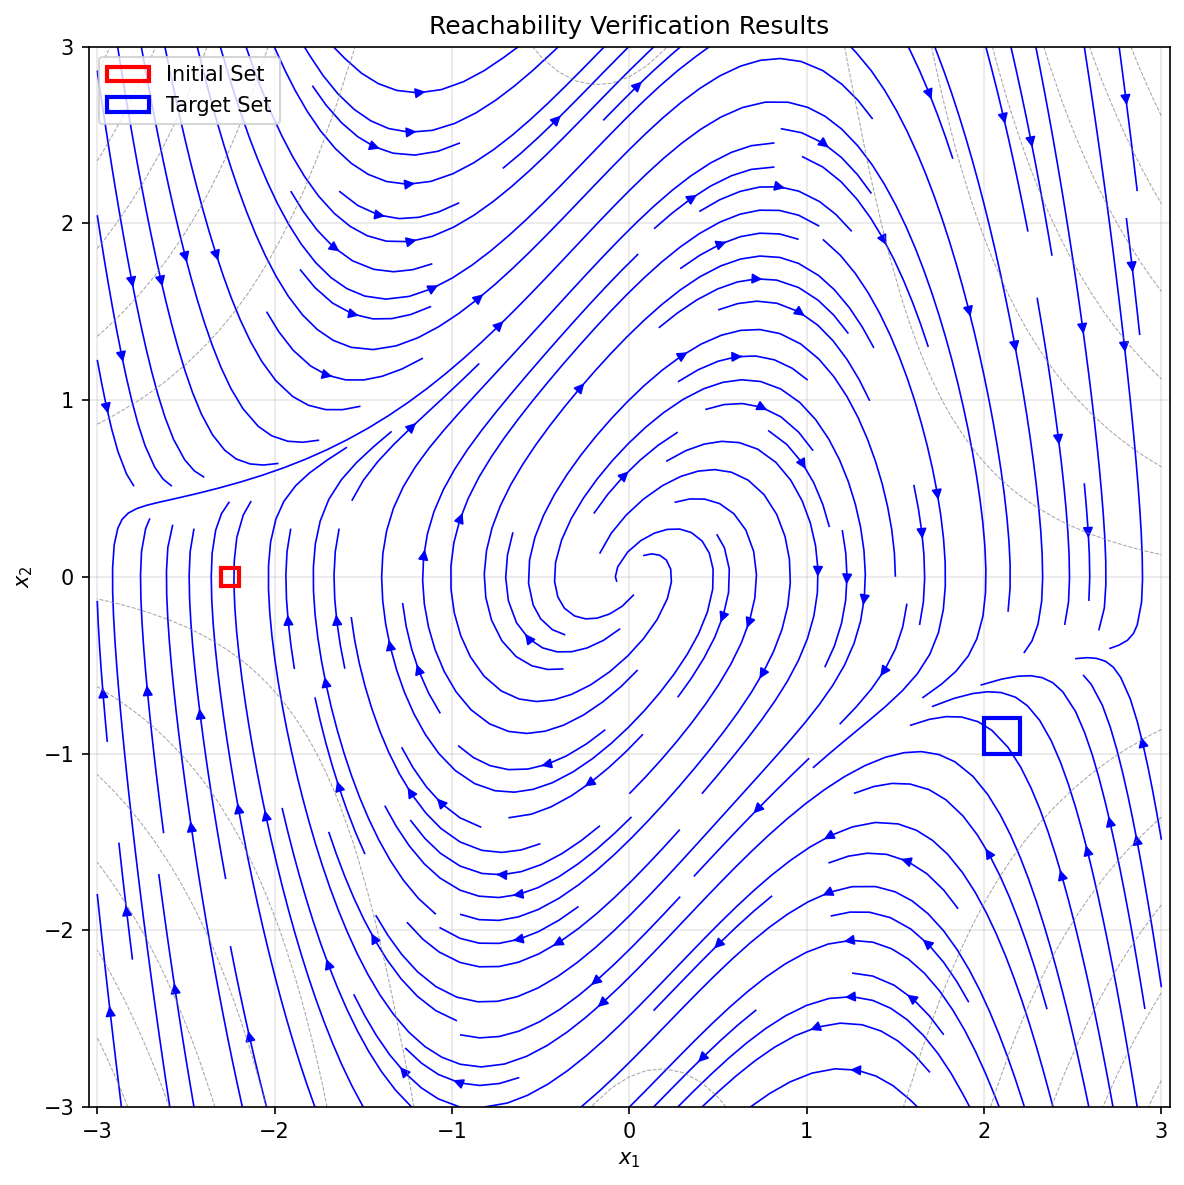

In [11]:
# now checking another initial set and target set

# CAUTION: for this settings, we got result that not align with the simulation

X0 = [[-2.3, -2.2], [-0.05, 0.05]]
XT = [[2.0, 2.2], [-1.0, -0.8]]

pts_X0 = ddrv.common.sample_box_set(X0, 500)
pts_XT = ddrv.common.sample_box_set(XT, 500)


print(pts_X0.shape, pts_XT.shape)

# evaluate the eigenfunctions on the initial set and the target set samples
ef0_vals = observables.eval_mod(pts_X0, V)
efT_vals = observables.eval_mod(pts_XT, V)
print(ef0_vals.shape, efT_vals.shape)

# compute the reach time bounds
time_bounds, status = ddrv.algo.compute_reach_time_bounds(ef0_vals, efT_vals, LAM_ct)

print(len(time_bounds), status)

# as we got quite many time bounds, for visualization, we juste pick the first 3 ones

# visualize the reachability verification result
ddrv.viz.vis_rv(
    vanderpol.get_numerical_dynamics(),
    domain=[[-3, 3], [-3, 3]],
    bounds=time_bounds[:3],
    dt=DT,
    initial_set=X0,
    target_set=XT,
)

(500, 2) (500, 2)
(500, 2) (500, 2)
[np.float64(3.4433576131926644),np.float64(31.73508516201905)] >>>> bound_mag
[np.float64(-1.823529531576481),np.float64(-1.4133683204292942)] >>>> bound_img
5 ('PROBABLY REACHABLE', 5)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


finshed simulation


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


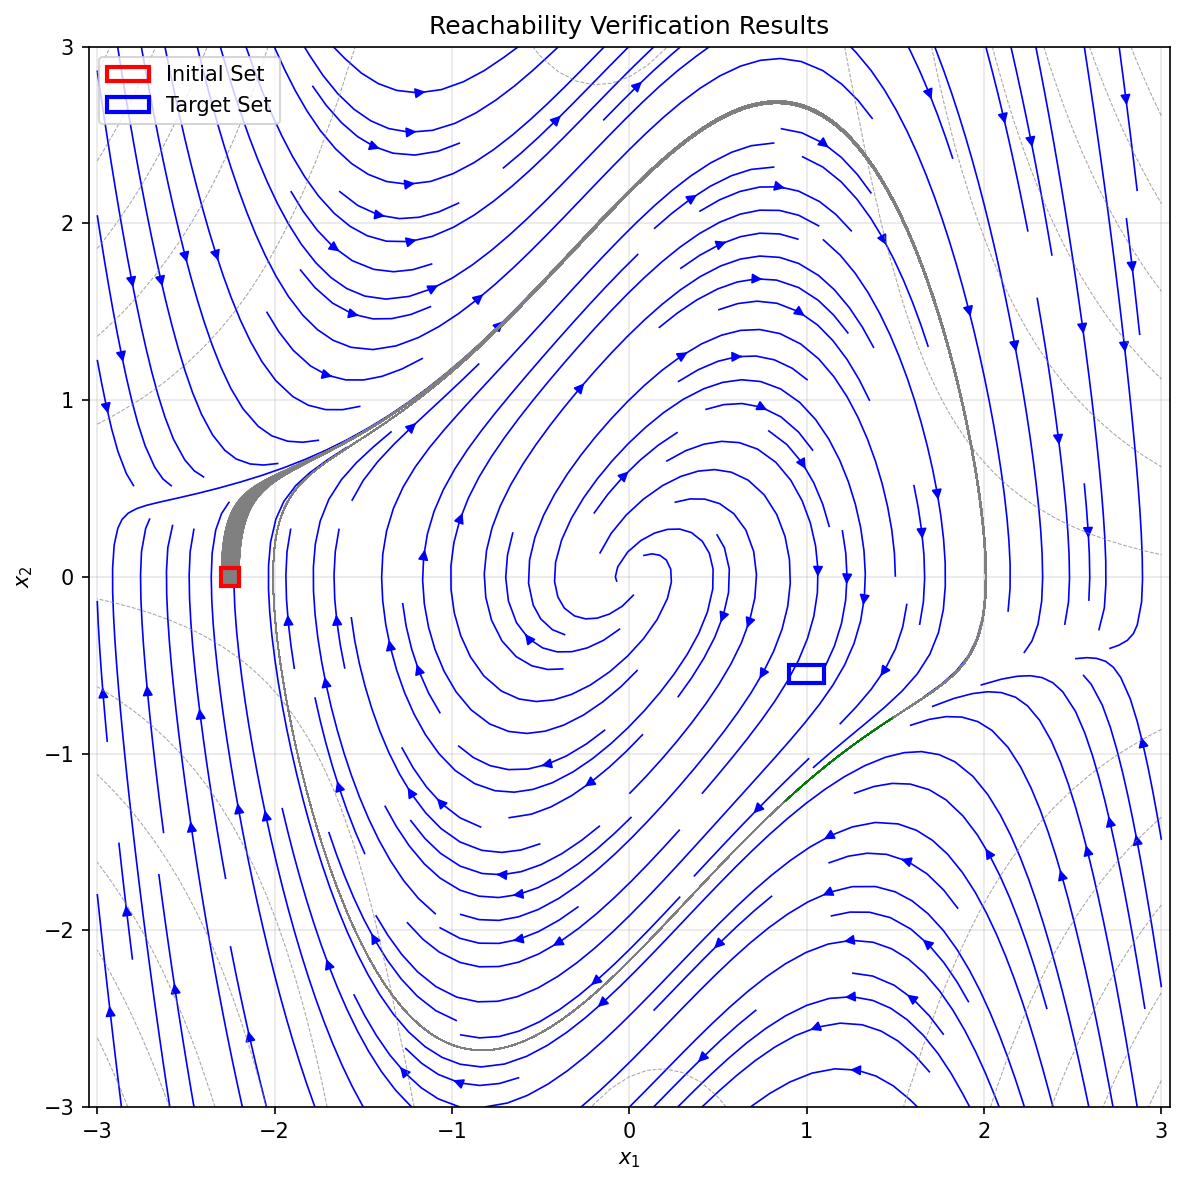

In [12]:
# now checking another initial set and target set

# CAUTION: for this settings, we got result that not align with the simulation

X0 = [[-2.3, -2.2], [-0.05, 0.05]]
XT = [[0.9, 1.1], [-0.6, -0.5]]

pts_X0 = ddrv.common.sample_box_set(X0, 500)
pts_XT = ddrv.common.sample_box_set(XT, 500)


print(pts_X0.shape, pts_XT.shape)

# evaluate the eigenfunctions on the initial set and the target set samples
ef0_vals = observables.eval_mod(pts_X0, V)
efT_vals = observables.eval_mod(pts_XT, V)
print(ef0_vals.shape, efT_vals.shape)

# compute the reach time bounds
time_bounds, status = ddrv.algo.compute_reach_time_bounds(ef0_vals, efT_vals, LAM_ct)

print(len(time_bounds), status)

# as we got quite many time bounds, for visualization, we juste pick the first 3 ones

# visualize the reachability verification result
ddrv.viz.vis_rv(
    vanderpol.get_numerical_dynamics(),
    domain=[[-3, 3], [-3, 3]],
    bounds=time_bounds[:3],
    dt=DT,
    initial_set=X0,
    target_set=XT,
)